<a href="https://colab.research.google.com/github/androbaza/Xsight-heart-rate/blob/main/resources/notebooks/XSight_pyVHR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='setup'></a>
#Initial setup 


In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 10.95 MiB/s, done.
Resolving deltas: 100% (136/136), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,498 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 

In [1]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:37
🔁 Restarting kernel...


In [1]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
done

## Package Plan ##

 

In [ ]:
%cd /content

In [8]:
!pip uninstall pyvhr

Found existing installation: pyVHR 1.0.2
Uninstalling pyVHR-1.0.2:
  Would remove:
    /usr/local/lib/python3.7/site-packages/pyVHR-1.0.2-py3.7.egg
Proceed (y/n)? y
  Successfully uninstalled pyVHR-1.0.2


In [3]:
!git clone https://github.com/phuselab/pyVHR
%cd ./pyVHR
!python setup.py install

Cloning into 'pyVHR'...
remote: Enumerating objects: 1405, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 1405 (delta 156), reused 152 (delta 137), pack-reused 1214
Receiving objects: 100% (1405/1405), 166.77 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (867/867), done.
/content/pyVHR
running install
/usr/local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/usr/local/lib/python3.7/site-packages/setuptools/command/easy_install.py:159: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  EasyInstallDeprecationWarning,
running bdist_egg
running egg_info
creating pyVHR.egg-info
writing pyVHR.egg-info/PKG-INFO
writing dependency_links to pyVHR.egg-info/dependency_links.txt
writing top

In [ ]:
!pip install mediapipe setuptools lmfit biosppy scikit_posthocs autorank #cusignal

In [9]:
!pip install pyvhr

     |████████████████████████████████| 114 kB 14.2 MB/s 


# CUDA devices:  1
# device number  0 :  Tesla T4

Processing Video: /content/3.mp4

BVP extraction with method: cupy_POS

BPM estimation with: welch

...done!



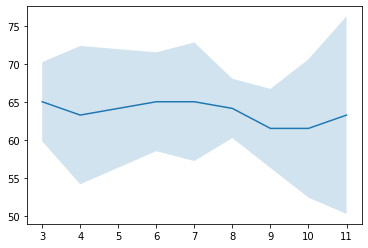

In [2]:
# import pyVHR
from pyVHR.analysis.pipeline import Pipeline
import matplotlib.pyplot as plt

pipe = Pipeline()
time, BPM, uncertainty = pipe.run_on_video('/content/3.mp4', roi_approach="patches", roi_method="faceparsing")

plt.figure()
plt.plot(time, BPM)
plt.fill_between(time, BPM-uncertainty, BPM+uncertainty, alpha=0.2)
plt.show()

# MTTS-CAN

**DeepPhys: Video-Based Physiological Measurement Using Convolutional Attention Networks**

*Weixuan Chen and Daniel McDuff*

**Abstract**. Non-contact video-based physiological measurement has many applications in health care and human-computer interaction. Practical applications require measurements to be accurate even in the presence of large head rotations. We propose the first end-to-end system for video-based measurement of heart and breathing rate using a deep convolutional network. The system features a new motion representation based on a skin reflection model and a new attention mechanism using appearance information to guide motion estimation, both of which enable robust measurement under heterogeneous lighting and major motions. Our approach significantly outperforms all current state-of-the-art methods on both RGB and infrared video datasets. Furthermore, it allows spatial-temporal distributions of physiological signals to be visualized via the attention mechanism.

papers: 
* [DeepPhys: Video-Based Physiological Measurement Using Convolutional Attention Networks](https://web.media.mit.edu/~cvx/docs/18.Chen-etal-ECCV.pdf), 
* [Multi-Task Temporal Shift Attention Networks for On-Device Contactless Vitals Measurement
](https://papers.nips.cc/paper/2020/file/e1228be46de6a0234ac22ded31417bc7-Paper.pdf)


In [ ]:
# extract raw frames
sp = vhr.extraction.sig_processing.SignalProcessing()
frames = sp.extract_raw(videoFileName)
print('Frames shape:', frames.shape)

# apply MTTS_CAN model
bvp_pred = vhr.deepRPPG.MTTS_CAN_deep(frames, fps, verb=1)
bvps = vhr.BPM.BVPsignal(bvp_pred, fps) # BVP object
vhr.plot.visualize_BVPs([bvps.data], 0)

In [ ]:
## -- analysis
from pyVHR.utils.errors import getErrors, printErrors, displayErrors, BVP_windowing
from pyVHR.extraction.utils import sliding_straded_win_offline

# BVP windowing & BPM estimate
bvp_win, timesES = BVP_windowing(bvp_pred, winSizeGT, fps, stride=1)
bpmES = vhr.BPM.BVP_to_BPM(bvp_win, fps) 

# compute and print errors
RMSE, MAE, MAX, PCC, CCC, SNR = vhr.utils.getErrors(bvp_win, fps, bpmES, bpmGT, timesES, timesGT)
vhr.utils.printErrors(RMSE, MAE, MAX, PCC, CCC, SNR)
displayErrors(bpmES, bpmGT, timesES, timesGT)

# Pipeline

In [ ]:
# run on a single video
from pyVHR.analysis.pipeline import DeepPipeline

filename = '/var/datasets/VHR1/UBFC1/after-exercise/vid.avi'

pipe = DeepPipeline()

time, BPM = pipe.run_on_video(filename, method='MTTS_CAN')